In [673]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt   #Data visualisation libraries 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

In [674]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_subf = pd.read_csv('sample_submission.csv')
rates = pd.read_csv('rates.csv', index_col=0, skiprows=0).T.to_dict()

In [675]:
# Replace price with price per passenger
df_train['price'] = df_train['price'] / df_train['number_of_passengers']
df_train['price'] = (df_train.apply(lambda x: (rates[x['currency']]['rate'] * x['price']), axis=1)).round(2)

In [676]:
def add_dep_info(df):
    df['departure_date'] = pd.to_datetime(df['departure_date'], format='%Y%m%d',exact=True)
    df['year'] = df.departure_date.dt.year.astype(str)
    # df['week'] = df.departure_date.dt.week.astype(str)
    df['month'] = df.departure_date.dt.month.astype(str)
    df['day'] = df.departure_date.dt.day.astype(str)
    return df

def add_arrival_info(dataset):    
    dataset['arrival_date'] = dataset.apply(lambda x: x['departure_date'] + timedelta(hours=x['eft']) + timedelta(hours=x['departure_time'] / 100) + timedelta(minutes=x['departure_time'] % 100),
                                            axis=1)    
    dataset['arrival_time'] = dataset.apply(lambda x: int('%s%s' % (x['arrival_date'].hour, x['arrival_date'].minute)),
                                           axis=1)
    return dataset

In [677]:
# Outliers
df_train = df_train.drop(df_train[df_train['id'] == 51950].index)
df_train = df_train.drop(df_train[df_train['id'] == 85045].index)
df_train = df_train.drop(df_train[df_train['id'] == 89623].index)
df_train = df_train.drop(df_train[df_train['id'] == 57157].index)
df_train = df_train.drop(df_train[df_train['id'] == 56666].index)
df_train = df_train.drop(df_train[df_train['id'] == 77202].index)
df_train = df_train.drop(df_train[df_train['id'] == 19741].index)

In [678]:
y=df_train['price']

In [679]:
df_train = df_train.drop(['price'],axis=1)
df = pd.concat([df_train, df_test],sort=False).reset_index(drop=True)
df.head(10)

,id,search_date,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,number_of_passengers,country,currency
0,1,20181212,BOS,ORD,1390,20181230,705,Sun,18,2.850,UA,M,N,738,2,US,USD
1,2,20181225,LAX,LAS,380,20181226,1455,Wed,1,1.250,AS,M,H,32S,2,GR,EUR
2,3,20181220,JFK,FLL,1723,20190112,2132,Sat,23,3.117,B6,M,P,321,3,US,USD
3,4,20181209,SEA,SFO,1093,20181213,950,Thu,4,2.267,AS,M,B,32S,1,AU,AUD
4,5,20181231,SFO,LAX,543,20190108,835,Tue,8,1.717,AA,M,L,E75,2,AU,AUD
5,6,20181214,SFO,FLL,4151,20190105,2359,Sat,22,5.283,B6,M,O,32S,2,US,USD
6,7,20181229,SFO,SEA,1093,20190104,920,Fri,6,2.217,UA,M,W,739,1,NL,EUR
7,8,20181221,ORD,MIA,1930,20190110,1905,Thu,20,3.117,UA,M,N,739,2,US,USD
8,9,20181205,ORD,SFO,2964,20190101,1650,Tue,27,5.133,AS,M,B,32S,4,GR,EUR
9,10,20181230,SFO,LAX,543,20190520,1420,Mon,141,1.583,AS,M,R,73J,1,HK,HKD


In [680]:
df_subf['number_of_passengers'] = df_test['number_of_passengers']
df_subf['currency'] = df_test['currency']

In [681]:
# Add deparutre info
df = add_dep_info(df)

# Add arrival info
df = add_arrival_info(df)

# Encode depature time/ aririval time
df['departure_time'] = df['departure_time'].apply(lambda x: int(x / 300)).astype(str)
df['arrival_time'] = df['arrival_time'].apply(lambda x: int(x / 300)).astype(str)

df['origin_destination'] = df_train['origin'] + '-' + df_train['destination']
df['is_weekend'] = df['departure_day_of_week'].apply(lambda x: x in ['Fri', 'Sat', 'Sun']).astype(str)
df['advance_purchase'] = df['advance_purchase'].apply(lambda x: x if x < 90 else 90)
df['advance_purchase']= np.log1p(df['advance_purchase'])


# df['distance']= np.log1p(df['distance'])
y= np.log1p(y)


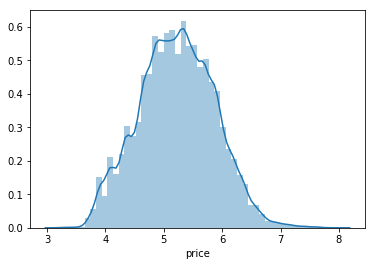

In [682]:
sns.distplot(y)


In [683]:
# df = df.sort_values(['origin_destination'], ascending=True)

In [684]:
df = df.drop([ 'search_date',
              'departure_date',
              'arrival_date',
              'number_of_passengers'
             ], axis = 1)
df.head()


,id,origin,destination,distance,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,...,aircraft,number_of_passengers,country,currency,year,month,day,arrival_time,origin_destination,is_weekend
0,1,BOS,ORD,1390,2,Sun,2.944439,2.850,UA,M,...,738,2,US,USD,2018,12,30,3,BOS-ORD,True
1,2,LAX,LAS,380,4,Wed,0.693147,1.250,AS,M,...,32S,2,GR,EUR,2018,12,26,5,LAX-LAS,False
2,3,JFK,FLL,1723,7,Sat,3.178054,3.117,B6,M,...,321,3,US,USD,2019,1,12,0,JFK-FLL,True
3,4,SEA,SFO,1093,3,Thu,1.609438,2.267,AS,M,...,32S,1,AU,AUD,2018,12,13,4,SEA-SFO,False
4,5,SFO,LAX,543,2,Tue,2.197225,1.717,AA,M,...,E75,2,AU,AUD,2019,1,8,3,SFO-LAX,False


In [685]:
df = pd.get_dummies(df)
df.head()

,id,distance,advance_purchase,eft,number_of_passengers,origin_ATL,origin_BOS,origin_DEN,origin_DFW,origin_EWR,...,origin_destination_SFO-FLL,origin_destination_SFO-JFK,origin_destination_SFO-LAS,origin_destination_SFO-LAX,origin_destination_SFO-MCO,origin_destination_SFO-MIA,origin_destination_SFO-ORD,origin_destination_SFO-SEA,is_weekend_False,is_weekend_True
0,1,1390,2.944439,2.850,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,380,0.693147,1.250,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1723,3.178054,3.117,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1093,1.609438,2.267,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,543,2.197225,1.717,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [686]:
df = df.drop(['id'], axis = 1)
X = df.iloc[:len(y),:]
X_sub = df.iloc[len(y):,:]


In [687]:
from sklearn.model_selection import train_test_split

In [688]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train.shape

(79994, 351)

In [689]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(np.expm1(y_true)), np.array(np.expm1(y_pred))
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Training

#### Random Forest

In [690]:
rf_model = RandomForestRegressor(bootstrap=True,
                                 criterion='mse',
                                 max_depth=None,
                                 max_features='auto',
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 min_samples_leaf=1,
                                 min_samples_split=2,                                 
                                 min_weight_fraction_leaf=0.0,
                                 n_estimators=10,
                                 n_jobs=-1,                                 
                                 oob_score=False,
                                 random_state=42,
                                 verbose=1,
                                 warm_start=False)

In [691]:
rf_model.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.1s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.2s finished


#### Predictions

In [692]:
predictions = rf_model.predict(np.array(X_test))
predictions

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


array([5.10036539, 4.83647168, 4.92086607, ..., 4.00680135, 5.19769074,
       4.72481519])

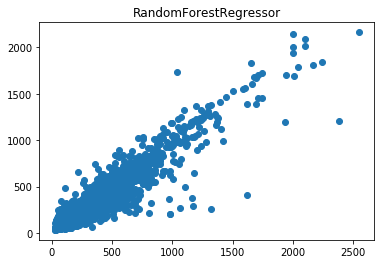

In [693]:
plt.title("RandomForestRegressor")
plt.scatter(np.expm1(y_test),np.expm1(predictions))

In [694]:
mean_absolute_percentage_error(y_test, predictions)

11.87525275477879

In [695]:
X_sub.head()

,distance,advance_purchase,eft,number_of_passengers,origin_ATL,origin_BOS,origin_DEN,origin_DFW,origin_EWR,origin_FLL,...,origin_destination_SFO-FLL,origin_destination_SFO-JFK,origin_destination_SFO-LAS,origin_destination_SFO-LAX,origin_destination_SFO-MCO,origin_destination_SFO-MIA,origin_destination_SFO-ORD,origin_destination_SFO-SEA,is_weekend_False,is_weekend_True
99993,1537,4.127134,3.183,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99994,1510,3.295837,2.900,4,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
99995,1510,3.465736,2.967,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
99996,1723,1.386294,2.817,4,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
99997,3494,2.772589,5.800,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [696]:
y_sub = rf_model.predict(X_sub)
# y_sub = rf_model.predict(np.array(X_sub))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


In [697]:
y_sub = np.expm1(y_sub)

In [698]:
def deNormailzeCurrency (label):
    if label['currency'] == 'USD':
        return label['price']
    elif label['currency'] == 'EUR':
        return np.float32(label['price']/1.12)
    elif label['currency'] == 'AUD':
        return (label['price'] /0.7)
    elif label['currency'] == 'HKD':
        return (label['price']/0.13)
    elif label['currency'] == 'INR':
        return (label['price']/0.014)
    elif label['currency'] == 'KRW':
        return (label['price']/0.00085)
    else :
        return -1

In [699]:
df_subf.iloc[:,1] = y_sub
df_subf.head()

,id,price,number_of_passengers,currency
0,100001,97.110415,2,INR
1,100002,126.474094,4,USD
2,100003,84.942280,4,USD
3,100004,394.184172,4,USD
4,100005,348.316076,1,USD


In [700]:
df_subf['price'] = (df_subf['price'] * np.float32(df_subf['number_of_passengers']))
df_subf['price'] = df_subf.apply (lambda row: deNormailzeCurrency(row), axis=1)
df_subf.head()

,id,price,number_of_passengers,currency
0,100001,13872.916387,2,INR
1,100002,505.896377,4,USD
2,100003,339.769118,4,USD
3,100004,1576.736687,4,USD
4,100005,348.316076,1,USD


In [701]:
df_subf.to_csv("sample_submission_result.csv", columns = ['id','price'], index = False)